In [2]:
import cv2
import numpy as np
from os.path import join
from matplotlib import pyplot as plt

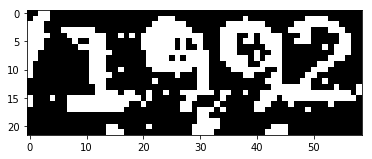

(22, 59)


In [3]:
plt.rcParams["figure.figsize"] = [6.0, 4.0]
img = cv2.imread('noise_yyyy.png', 0)
# img = img[:, 3:]
h, w = img.shape
plt.imshow(img, cmap='gray')
# plt.imshow(img[:, int(w/2):], cmap='gray')
plt.show()
print(img.shape)

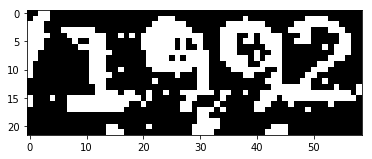

In [4]:
_, thresh = cv2.threshold(img, 127, 255, 0)
plt.imshow(thresh, cmap='gray')
plt.show()

Number of contours: 19


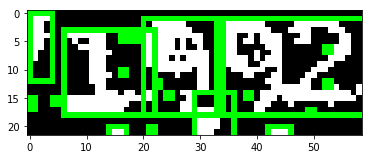

In [6]:
img2, contours, hierarchy = cv2.findContours(thresh,
                                             mode=cv2.RETR_EXTERNAL,
                                             method=2)
# img2, contours, hierarchy = cv2.findContours(thresh, mode=1, method=2)
thresh_coloured = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

num_contours = len(contours)
contour_areas = [0] * num_contours
heights = [0] * num_contours

print('Number of contours:', num_contours)
img_height = thresh_coloured.shape[0]

for i in range(0, num_contours):
    x,y,w,h = cv2.boundingRect(contours[i])
    heights[i] = h / img_height
    cv2.rectangle(thresh_coloured, (x, y),(x + w, y + h), (0, 255, 0), 1)
    contour_areas[i] = w * h
plt.imshow(thresh_coloured, cmap = 'gray')
plt.show()

In [ ]:
import numpy as np
img_type = 'yyyy'

h, w = img.shape
img_area = h * w
if img_type == 'dd_mm':
    num_digits = 2
elif img_type == 'yyyy':
    num_digits = 4

desc_area_contour_idx = np.flipud(np.argsort(np.array(contour_areas)))
print()

In [7]:
from math import floor
def square_padding(ori_img):
    squared_img = ori_img
    height, width = ori_img.shape
    if (width != height):
        BLACK = [0, 0, 0]
        if (width > height):
            diff = width - height
            if (diff % 2 == 0):
                padding = int(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, padding, padding, 0, 0, cv2.BORDER_CONSTANT,value=BLACK)
            else:
                padding = floor(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, padding+1, padding, 0,0, cv2.BORDER_CONSTANT,value=BLACK)
        else:
            diff = height - width
            if (diff % 2 == 0):
                padding = int(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, 0, 0, padding, padding, cv2.BORDER_CONSTANT,value=BLACK)
            else:
                padding = floor(diff / 2)
                squared_img = cv2.copyMakeBorder(ori_img, 0,0, padding+1, padding, cv2.BORDER_CONSTANT,value=BLACK)
    return squared_img

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
_net = caffe.Net('../lenet_deploy.prototxt', '../lenet_iter_100000.caffemodel', caffe.TEST)

def numberSeq2Str(digit_img_arr, net):
    id_str = ''
    for digit in digit_img_arr:
        digit = cv2.resize(digit, (28, 28))
#         print(digit.shape)
#         digit = digit.astype(np.dtype(np.float64)) * (1.0 / 255.0)
        digit = digit.astype(np.float64) * (1.0 / 255.0)
        net.blobs['data'].data[...] = digit[np.newaxis, np.newaxis, :, :]
        out = _net.forward()
        id_str += str(out['prob'].argmax())
    return id_str

In [8]:
import numpy as np
img_type = 'yyyy'

_, w = img.shape
if img_type == 'dd_mm':
    num_digits = 2
elif img_type == 'yyyy':
    num_digits = 4

# img = dob_full_img[:, 148-64:]
digit_img = [None] * num_digits
chunk_w = int(w / num_digits)
for i in range(num_digits):
    start_pixel = i * chunk_w
    digit_img[i] = img[:, start_pixel:start_pixel + chunk_w]
#     digit_img[1] = img[:, int(w/2):]

for i in range(len(digit_img)):
    # img_area = digit_img.shape[0] * digit_img.shape[1]
    _, thresh = cv2.threshold(digit_img[i], 127, 255, 0)
    _, contours, _ = cv2.findContours(thresh, mode=cv2.RETR_EXTERNAL, method=2)

    num_contours = len(contours)
    rect = [None] * num_contours
    contour_areas = [0.] * num_contours

    for j in range(num_contours):
        x, y, w, h = cv2.boundingRect(contours[j])
        rect[j] = (x, y, w, h)
        contour_areas[j] = w * h

    desc_cnt_idx = np.flipud(np.argsort(np.array(contour_areas)))
    (x, y, w, h) = rect[desc_cnt_idx[0]]
    digit_img[i] = square_padding(digit_img[i][y:y + h, x:x + w])
    cv2.imwrite(str(i)+'.png', digit_img[i])
(numberSeq2Str(digit_img, _net))

'3600'